In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from accelerate import Accelerator
import multiprocessing as mp
from learning_tool import *
import sys
sys.path.append('..')

from model.model import *

2023-08-01 15:25:34.707333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 15:25:35.447610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm.notebook import tqdm
from IPython.display import display
from sklearn.model_selection import train_test_split

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# デバイスの割り当て

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# device = torch.device('cpu')
# デバイスの指定
accelerator = Accelerator()
device = accelerator.device

In [5]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
# 乱数初期化
torch_seed()

In [6]:
df = pd.read_csv('../resource/txt_vec_and_label_camel_10.csv', index_col=0)
df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,contains_bug
commit_hash,,,,,,,,,,,,,,,,,,,,,
77b260b65ba821b3443d922320cc3d9b708c8d83,5,5,40,56,26,36,11,9,12,5,...,11,106,9,1,12,1,5,1,38,1
a4701ac4bf5b50810914796e284b0e3f78a240bc,5,40,56,26,36,11,9,12,5,151,...,0,0,0,0,0,0,0,0,0,1
0a0bad2c4a35be88f7732def261a03737fab662e,5,40,56,26,36,11,9,12,5,718,...,46,1,13,24,1,13,376,3,2,1
4de90eba5a4628f573c5e0536ed9160b6f1ea29d,538,26,36,11,9,12,5,135,61,135,...,0,0,0,0,0,0,0,0,0,0
4292f69f0afd36a7335515cc565ea41521bfa5cd,5,40,56,26,36,11,9,12,5,38,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
da0d0426ebf80387c4eb5f169bed5df813dd22da,5,40,56,26,36,11,9,12,5,20,...,0,0,0,0,0,0,0,0,0,0
f3f792e763685511088a10afb2d58a75ac131421,5,40,56,26,36,11,9,12,5,5,...,4,51,1,20,19,10,20,19,4,1
f59887aeaf409d5282548a5d559f5ce58c43c601,5,40,56,26,36,11,9,12,5,132,...,0,0,0,0,0,0,0,0,0,1


In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, features, labels):
        self.features_values = df[features].values
        self.labels = df[labels].values
        
    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.LongTensor(self.features_values[idx])
        labels = torch.as_tensor(self.labels[idx])
        return features_x, labels

In [8]:
columns = df.columns.values
features_columns = columns[:-1]
labels_column = columns[-1]
print(features_columns)
print(labels_column)
dataset = MyDataset(df, features_columns, labels_column)

['0' '1' '2' ... '1997' '1998' '1999']
contains_bug


In [9]:
df['contains_bug'].value_counts() / df.shape[0]

contains_bug
0    0.630281
1    0.369719
Name: count, dtype: float64

In [10]:
len(dataset[0][0])

2000

In [11]:
n_samples = len(dataset) # n_samples is 27000
train_size = int(len(dataset) * 0.9) # train_size 
test_size = n_samples - train_size # val_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(train_set))
print(len(test_set))

23325
2592


In [12]:
for data, label in train_set:
    break
print(data.dtype, label.dtype)

torch.int64 torch.int64


In [13]:
numDataPoints = len(train_set)
data_dim = len(train_set[0][0])

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.zeros(0)
target = (np.hstack(data[1].numpy() for data in train_set))
target
print(target)
print ('target train 0/1: {}/{}'.format(
    len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

[0 1 0 ... 1 0 0]
target train 0/1: 14649/8676


In [14]:
batch_size = 75

train_loader = DataLoader(train_set,
                          sampler=sampler,
                         batch_size = batch_size,
                          shuffle = False,
                          num_workers = 8
                         )
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers = 8)

In [15]:
for vec, labels in train_loader:
    # break
# print(labels)
    output, counts  = torch.unique(labels, return_counts=True)
# print(output)
    # print(counts)
    # break

In [16]:
n_output = 2
n_hidden = 100
print(f'n_hidden: {n_hidden} n_output: {n_output}')

n_hidden: 100 n_output: 2


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torcheval.metrics.functional import multiclass_auroc

# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history, inputs_auc_test, labels_auc_test):
    
    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        train_acc, test_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, test_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0
       
        # print(device)
        #訓練フェーズ
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size
    
            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            accelerator.backward(loss)

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]
            
            # statistics
            train_loss += loss * inputs.size(0)
            train_acc += torch.sum(predicted == labels.data)
            
            all_running_train_loss = accelerator.gather(train_loss)
            all_running_train_acc = accelerator.gather(train_acc)
            
            if accelerator.is_local_main_process:
                epoch_train_loss = all_running_train_loss.sum().item() / len(train_loader.dataset)
                epoch_train_acc = all_running_train_acc.sum().double() / len(train_loader.dataset)
            # # 平均前の損失と正解数の計算
            # # lossは平均計算が行われているので平均前の損失に戻して加算
            # train_loss += loss.item() * train_batch_size 
            # n_train_acc += (predicted == labels).sum().item() 
            # # print(n_train_acc / n_train)
        
        #予測フェーズ
        net.eval()
        with torch.no_grad():
            for inputs_test, labels_test in test_loader:
                # 1バッチあたりのデータ件数
                test_batch_size = len(labels_test)
                # 1エポックあたりのデータ累積件数
                n_test += test_batch_size

                # GPUヘ転送
                inputs_test = inputs_test.to(device)
                labels_test = labels_test.to(device)

                # 予測計算
                outputs_test = net(inputs_test)

                # 損失計算
                loss_test = criterion(outputs_test, labels_test)

                # 予測ラベル導出
                predicted_test = torch.max(outputs_test, 1)[1]
                
                
                test_loss += loss_test * inputs_test.size(0)
                test_acc += torch.sum(predicted_test == labels_test.data)
            
                all_running_test_loss = accelerator.gather(test_loss)
                all_running_test_acc = accelerator.gather(test_acc)
                
                if accelerator.is_local_main_process:
                    epoch_test_loss = all_running_test_loss.sum().item() / len(test_loader.dataset)
                    epoch_test_acc = all_running_test_acc.sum().double() / len(test_loader.dataset)
                    
        #AUC
        auc_score = cal_auc(net, inputs_auc_test, labels_auc_test, device)
        
        epoch_train_loss = epoch_train_loss
        epoch_train_acc = epoch_train_acc.to("cpu").numpy() 
        epoch_test_loss  = epoch_test_loss 
        epoch_test_acc = epoch_test_acc.to("cpu").numpy() 
        
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {epoch_train_loss:.5f} acc: {epoch_train_acc:.5f} test_loss: {epoch_test_loss:.5f}, test_acc: {epoch_test_acc:.5f}, auc_score: {auc_score:.5f}')
        # 記録
        item = np.array([epoch+1, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc, auc_score])
        history = np.vstack((history, item))

    return history
    

def cal_auc(net, inputs_auc_test, labels_auc_test, device):
    
    class_cnt = len(torch.unique(labels_auc_test))
    with torch.no_grad():
        inputs_auc_test = inputs_auc_test.to(device)
        labels_auc_test = labels_auc_test.to(device)
        outputs_test = net(inputs_auc_test)
        auc = multiclass_auroc(
            input = outputs_test,
            target = labels_auc_test,
            num_classes = class_cnt,
            average="macro"
        ).item()
    
    return auc


In [18]:
inputs_auc_test = np.zeros((0,2000), dtype=np.int64)
inputs_auc_test = torch.tensor(inputs_auc_test, dtype=torch.int64)
labels_auc_test = np.zeros(0, dtype=np.int64)
labels_auc_test = torch.tensor(labels_auc_test, dtype=torch.int64)
    
for data, label in test_set:
    inputs_auc_test = torch.vstack((inputs_auc_test, data))
    labels_auc_test = torch.hstack((labels_auc_test, label))

In [19]:
net = CNN(n_output, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.0001

optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

net, optimizer, train_loader, test_loader = accelerator.prepare(
    net, optimizer, train_loader, test_loader)
num_epochs = 50

history = np.zeros((0,6))

history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history, inputs_auc_test, labels_auc_test)

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72458 acc: 0.61188 test_loss: 0.55885, test_acc: 0.71836, auc_score: 0.76715


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63556 acc: 0.66422 test_loss: 0.58917, test_acc: 0.68750, auc_score: 0.77441


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60642 acc: 0.67751 test_loss: 0.57465, test_acc: 0.70679, auc_score: 0.77905


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58658 acc: 0.68853 test_loss: 0.58216, test_acc: 0.69985, auc_score: 0.78201


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57621 acc: 0.69882 test_loss: 0.55660, test_acc: 0.72106, auc_score: 0.78301


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56965 acc: 0.70469 test_loss: 0.54722, test_acc: 0.72801, auc_score: 0.78671


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.55911 acc: 0.71061 test_loss: 0.57122, test_acc: 0.71142, auc_score: 0.78782


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55482 acc: 0.71777 test_loss: 0.54037, test_acc: 0.73110, auc_score: 0.78769


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55711 acc: 0.70920 test_loss: 0.54865, test_acc: 0.72724, auc_score: 0.78896


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55049 acc: 0.71670 test_loss: 0.53639, test_acc: 0.73495, auc_score: 0.79056


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55235 acc: 0.71914 test_loss: 0.55473, test_acc: 0.72492, auc_score: 0.79220


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54922 acc: 0.71627 test_loss: 0.53912, test_acc: 0.73688, auc_score: 0.79292


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54074 acc: 0.72643 test_loss: 0.53680, test_acc: 0.73380, auc_score: 0.79438


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.54296 acc: 0.72613 test_loss: 0.54500, test_acc: 0.72994, auc_score: 0.79398


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53820 acc: 0.72999 test_loss: 0.53362, test_acc: 0.73958, auc_score: 0.79230


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53606 acc: 0.73162 test_loss: 0.55131, test_acc: 0.73187, auc_score: 0.79541


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.53600 acc: 0.72793 test_loss: 0.55008, test_acc: 0.72724, auc_score: 0.79568


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.53365 acc: 0.73235 test_loss: 0.53967, test_acc: 0.73071, auc_score: 0.79565


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.53674 acc: 0.73441 test_loss: 0.55000, test_acc: 0.72801, auc_score: 0.79556


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.53120 acc: 0.73565 test_loss: 0.54619, test_acc: 0.72955, auc_score: 0.79921


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.52738 acc: 0.73934 test_loss: 0.54701, test_acc: 0.73187, auc_score: 0.79933


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.52670 acc: 0.73548 test_loss: 0.53307, test_acc: 0.73920, auc_score: 0.80061


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.52406 acc: 0.74006 test_loss: 0.52994, test_acc: 0.74306, auc_score: 0.80205


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.52341 acc: 0.74049 test_loss: 0.53335, test_acc: 0.73727, auc_score: 0.80041


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.51737 acc: 0.74770 test_loss: 0.54972, test_acc: 0.72801, auc_score: 0.80116


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.51808 acc: 0.74461 test_loss: 0.52547, test_acc: 0.74730, auc_score: 0.80047


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.51973 acc: 0.74555 test_loss: 0.53558, test_acc: 0.73573, auc_score: 0.80231


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.51636 acc: 0.74354 test_loss: 0.53419, test_acc: 0.73727, auc_score: 0.80297


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.51056 acc: 0.75395 test_loss: 0.53893, test_acc: 0.74035, auc_score: 0.80055


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.51021 acc: 0.75078 test_loss: 0.52694, test_acc: 0.74190, auc_score: 0.80363


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.51881 acc: 0.74581 test_loss: 0.52760, test_acc: 0.74460, auc_score: 0.80269


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.51250 acc: 0.75040 test_loss: 0.52455, test_acc: 0.74421, auc_score: 0.80261


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.50667 acc: 0.75387 test_loss: 0.53028, test_acc: 0.73727, auc_score: 0.80095


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.51171 acc: 0.74765 test_loss: 0.54057, test_acc: 0.73341, auc_score: 0.80276


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.50658 acc: 0.75747 test_loss: 0.53383, test_acc: 0.74074, auc_score: 0.80154


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.50977 acc: 0.74920 test_loss: 0.54151, test_acc: 0.73380, auc_score: 0.80292


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.50260 acc: 0.75764 test_loss: 0.53055, test_acc: 0.74267, auc_score: 0.80181


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.50509 acc: 0.75571 test_loss: 0.53687, test_acc: 0.73418, auc_score: 0.80337


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.51187 acc: 0.75344 test_loss: 0.51978, test_acc: 0.74537, auc_score: 0.80512


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.50870 acc: 0.75083 test_loss: 0.53712, test_acc: 0.73727, auc_score: 0.80305


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.50449 acc: 0.75833 test_loss: 0.52933, test_acc: 0.74190, auc_score: 0.80382


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.51021 acc: 0.75267 test_loss: 0.54348, test_acc: 0.73573, auc_score: 0.80310


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.50363 acc: 0.75790 test_loss: 0.53417, test_acc: 0.74035, auc_score: 0.80189


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.50468 acc: 0.75833 test_loss: 0.53974, test_acc: 0.73534, auc_score: 0.80389


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.50531 acc: 0.75460 test_loss: 0.53829, test_acc: 0.74113, auc_score: 0.80279


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.51005 acc: 0.75121 test_loss: 0.53805, test_acc: 0.73881, auc_score: 0.80330


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.51250 acc: 0.75177 test_loss: 0.52763, test_acc: 0.74576, auc_score: 0.80473


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.50666 acc: 0.75610 test_loss: 0.53647, test_acc: 0.73997, auc_score: 0.80287


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.50994 acc: 0.75387 test_loss: 0.53491, test_acc: 0.74190, auc_score: 0.80416


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.51080 acc: 0.75254 test_loss: 0.55479, test_acc: 0.73032, auc_score: 0.80266


初期状態: 損失: 0.55885 精度: 0.71836
最終状態: 損失: 0.55479 精度: 0.73032


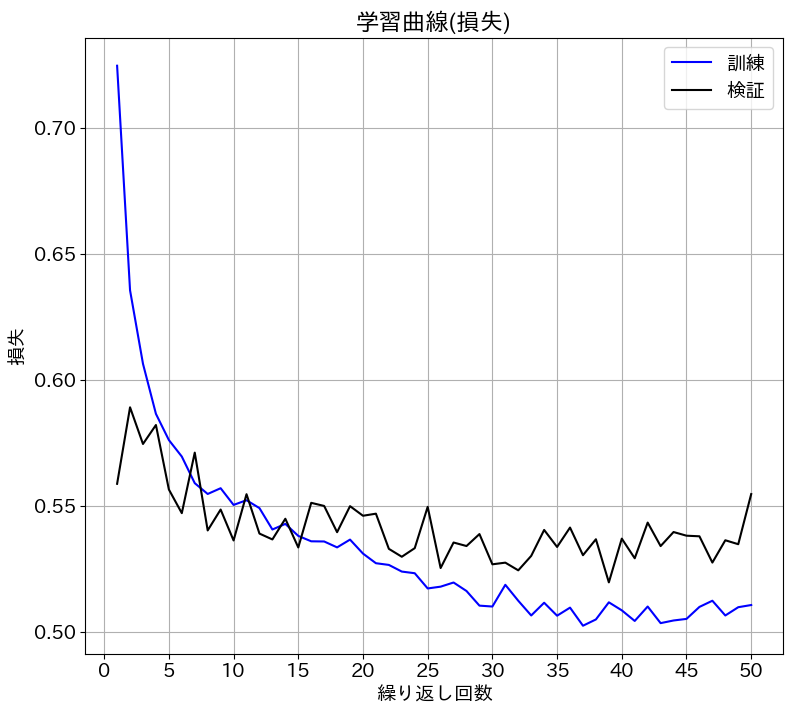

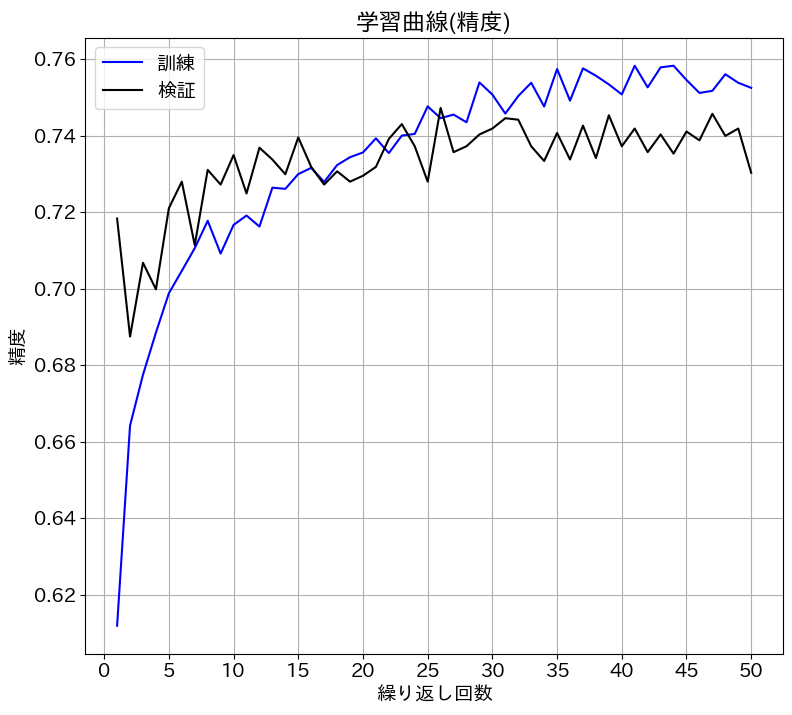

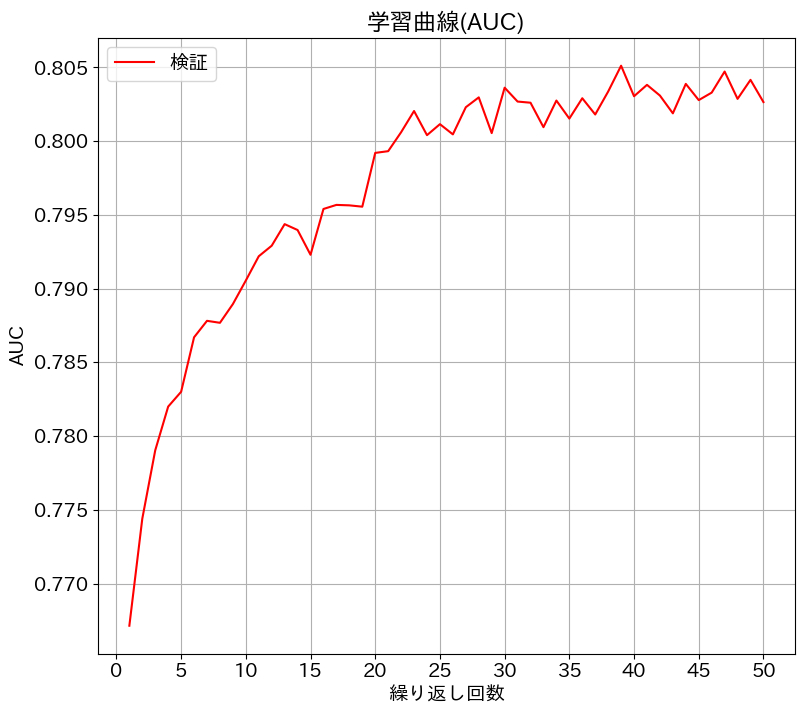

In [20]:
evaluate_history(history)